<style>
  .navbar {
    background-color: #f7f7f7;
    display: flex;
    justify-content: space-between;
    align-items: center;
    overflow: hidden;
    font-family: 'Montserrat', 'Arial', sans-serif;
    padding: 10px;
    height: 90px;
    box-shadow: 0 2px 4px rgba(0,0,0,0.2);
  }

  .navbar a {
    font-size: 18px;
    text-align: center;
    padding: 14px 16px;
    text-decoration: none;
    transition: color 0.3s ease-in-out;
    color: #0f5b99
  }

  .navbar a:hover {
    background-color: #eaeaea;
    color: #ff5500;
  }

  .navbar img {
    height: 'auto';
    width: 300px
  }
</style>

<div class="navbar" id="inizio">
  <a href="descrizione_problema.html">Descrizione del problema</a>
  <a href="data_preprocessing.html">Data Preprocessing</a>
  <a href="approccio_3D.html">Approccio 3D</a>
  <a href="approccio_2D.html">Approccio 2D</a>
  <a href="https://www.unipa.it"><img src="https://www.unipa.it/redazioneweb/.content/immagini/logo-unipa-2020.png"></a>
</div>


# <strong> <center> STYLING DEL NOTEBOOK </center> </strong>
---

In [1]:
from IPython.core.display import HTML

HTML("""
        <style>
            @import url('https://fonts.googleapis.com/css?family=Montserrat&display=swap');
            
            * {
                font-family: 'Montserrat', 'Arial', sans-serif;
            }

        </style>
    """)

## Creazione delle progress bar personalizzate

In [ ]:
bar_format_red = "{l_bar}\x1b[31m{bar}\x1b[0m{r_bar}]"
bar_format_green = "{l_bar}\x1b[32m{bar}\x1b[0m{r_bar}]"
bar_format_yellow = "{l_bar}\x1b[33m{bar}\x1b[0m{r_bar}]"
bar_format_blue = "{l_bar}\x1b[34m{bar}\x1b[0m{r_bar}]"
bar_format_magenta = "{l_bar}\x1b[35m{bar}\x1b[0m{r_bar}]"
bar_format_cyan = "{l_bar}\x1b[36m{bar}\x1b[0m{r_bar}]"

# <center id='paragrafo_9'> <strong> APPROCCIO 2D </strong> </center>
---

In parallelo al secondo approccio con **U-Net 3D** abbiamo deciso, vista la poca quantità di volumi, di tentare anche un approccio bidimensionale.

## Generazione del dataset

Al fine di poter effettuare la fase di trainig su **Google Colab** e **Kaggle**, due piattaforme di sviluppo gratuite che permettono l'uso di GPU performanti in cloud computing, abbiamo deciso di generare il dataset in locale e di comprimerlo in un archivio zip, di dimensioni più ridotte e facilmente caricabile sul cloud senza che si verificasse la perdita di immagini.

### Elenco `import`

In [ ]:
import os
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import zipfile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Elenco `path`

In [ ]:
DATAFRAMES_DIR = os.path.join('./dataframes/')
DATASET_2D_DIR = os.path.join('./dataset_2D/')

TRAINING_DIR = os.path.join(f'{DATASET_2D_DIR}train/')
SLICES_TRAIN_DIR = os.path.join(f'{TRAINING_DIR}slices/')
MASKS_TRAIN_DIR = os.path.join(f'{TRAINING_DIR}masks/')

TEST_DIR = os.path.join(f'{DATASET_2D_DIR}test/')
SLICES_TEST_DIR = os.path.join(f'{TEST_DIR}slices/')
MASKS_TEST_DIR = os.path.join(f'{TEST_DIR}masks/')

VALIDATION_DIR = os.path.join(f'{DATASET_2D_DIR}validation/')
SLICES_VALIDATION_DIR = os.path.join(f'{VALIDATION_DIR}slices/')
MASKS_VALIDATION_DIR = os.path.join(f'{VALIDATION_DIR}masks/')

### Creazione cartelle

Per automatizzare il processo di generazione di cartelle e sotto-cartelle, utilizziamo la libreria `os` per effettuare dei semplici controlli e, dipendentemente dall'esito, procedere alla creazione della struttura delle directory.

In [ ]:
if not os.path.exists(DATASET_2D_DIR):
    os.mkdir(DATASET_2D_DIR) 
    os.mkdir(TRAINING_DIR) 
    os.mkdir(SLICES_TRAIN_DIR)
    os.mkdir(MASKS_TRAIN_DIR)

if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR) 
    os.mkdir(SLICES_TEST_DIR)
    os.mkdir(MASKS_TEST_DIR)

if not os.path.exists(VALIDATION_DIR):
    os.mkdir(VALIDATION_DIR) 
    os.mkdir(SLICES_VALIDATION_DIR)
    os.mkdir(MASKS_VALIDATION_DIR)

### Considerazioni preliminari

Tutte le operazioni di pre-processamento sono servite ad avere immagini della stessa dimensione e con una resa migliore. 

Come effetto collaterale, si è verificata l'aggiunta di nuovi valori unici alle maschere di segmentazione.

Inizialmente, queste maschere contenevano solo 4 valori unici di intensità dei pixel, utili a distinguere la presenza di background, small bowel, large bowel e stomach.

Il cambiamento nel numero di classi presenti nella maschera potrebbe essere dovuto a una diversa rappresentazione dei valori pixel dopo l'applicazione delle trasformazioni.

Di seguito, mostriamo un esempio di quanto accaduto:

In [ ]:
img = cv.imread('../mask_slice_0067_266_266_1.50_1.50.png', cv.IMREAD_GRAYSCALE)

unique_values = np.unique(img)
num_classes = len(unique_values)

print(f"Numero di classi presenti nella maschera: {num_classes}")
print(f"Valori unici presenti nella maschera: {unique_values}")

Numero di classi presenti nella maschera: 157
Valori unici presenti nella maschera: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  21  22  24  25  27  28  29  30  31  32  34  35  37  38  39  40  41
  44  45  46  47  48  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  74  75  77  78  79  80  82  83  84
  85  86  87  88  89  90  91  92  93  97  99 101 102 103 107 108 109 111
 112 116 117 118 119 121 124 125 126 127 129 130 131 132 134 136 139 140
 141 142 143 144 145 147 148 149 150 151 153 154 155 156 157 159 160 163
 165 167 168 171 172 176 177 179 180 181 182 183 191 195 200 206 211 214
 217 221 222 223 225 228 231 232 236 237 238 239 240]


Per riportare le maschere ai 4 valori unici di partenza, andiamo a creare una nuova immagine, che avrà le caratteristiche di quella di partenza, ma dove andremo a riportare solo i valori a noi di interesse, in modo tale da effettuare una distinzione nitida tra le classi.

Ecco il procedimento applicato ad una sola immagine:

In [ ]:
new_img = np.zeros_like(img)

new_img[img == 0] = 0
new_img[img == 80] = 1
new_img[img == 160] = 2
new_img[img == 240] = 3

unique_values = np.unique(new_img)
num_classes = len(unique_values)

print(f"Numero di classi presenti nelle maschere: {num_classes}")
print(f"Valori unici presenti nelle maschere: {unique_values}")

Numero di classi presenti nelle maschere: 4
Valori unici presenti nelle maschere: [0 1 2 3]


Così facendo, abbiamo potuto usare la funzione `to_categorical` del modulo `keras.utils` per convertire le etichette di un problema di classificazione multiclasse in una rappresentazione categorica. 

Questa funzione prende come **input** un **vettore a valori discreti** e il **numero totale di classi possibili** ($4$), e restituisce in **output** una **matrice binaria in rappresentazione *one-hot*** che rappresenta le etichette in forma categorica, seguendo un processo di **binarizzazione**.

Per ogni etichetta, il valore $1$ è assegnato alla colonna corrispondente alla sua classe, mentre tutte le altre colonne hanno valori $0$.

Di seguito, mostriamo un esempio di quanto esposto:

(256, 256, 4)


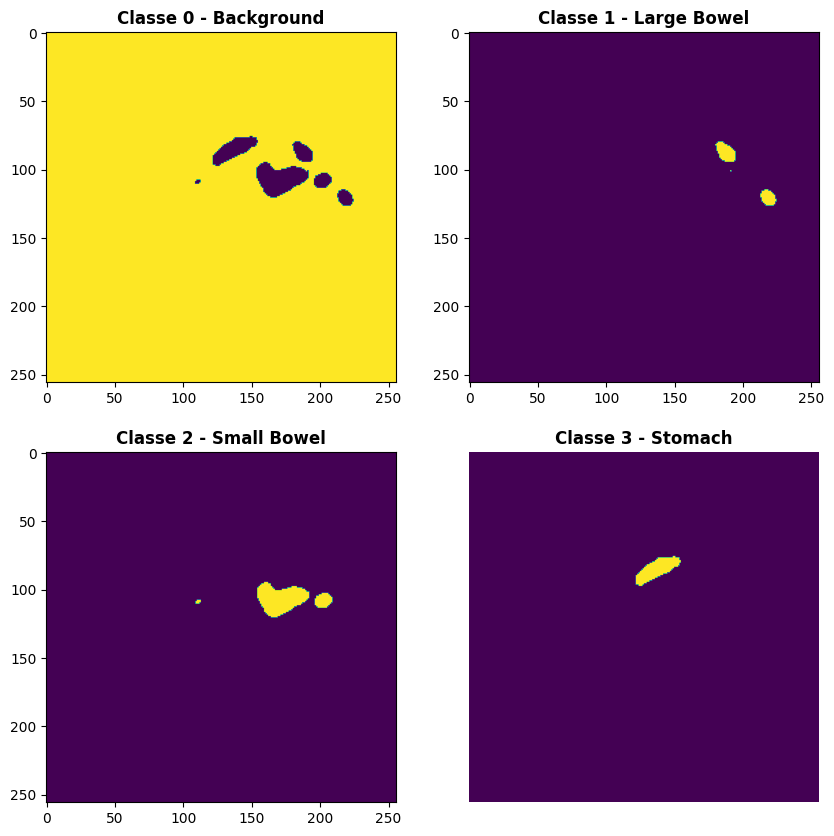

In [ ]:
new_img = to_categorical(np.asarray(new_img), num_classes=4)

print(new_img.shape)

class_0 = new_img[:, :, 0]
class_1 = new_img[:, :, 1]
class_2 = new_img[:, :, 2]
class_3 = new_img[:, :, 3]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(class_0)
axs[0, 0].set_title('Classe 0 - Background', fontweight='bold')

axs[0, 1].imshow(class_1)
axs[0, 1].set_title('Classe 1 - Large Bowel', fontweight='bold')

axs[1, 0].imshow(class_2)
axs[1, 0].set_title('Classe 2 - Small Bowel', fontweight='bold')

axs[1, 1].imshow(class_3)
axs[1, 1].set_title('Classe 3 - Stomach', fontweight='bold')

plt.axis('off')

# Visualizzazione dell'immagine
plt.show()

Procediamo adesso alla generazione del dataset vera e propria.

In [ ]:
merged_df_w_segmentation = pd.read_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv')

slices = []
masks = []

for mask in tqdm(merged_df_w_segmentation['mask_path'], bar_format=bar_format_red):
    img = cv.imread(mask, cv.IMREAD_GRAYSCALE)
    masks.append(img)
    
for scan in tqdm(merged_df_w_segmentation['slice_path'], bar_format=bar_format_blue):
    img = cv.imread(scan, cv.IMREAD_GRAYSCALE)
    slices.append(img)
    
masks = np.array(masks)
slices = np.array(slices)

new_masks = np.zeros_like(masks)

print(masks.shape)
print(new_masks.shape)

new_masks[masks == 0] = 0
new_masks[masks == 80] = 1
new_masks[masks == 160] = 2
new_masks[masks == 240] = 3

100%|██████████| 16590/16590 [00:21<00:00, 775.45it/s]] 


(16590, 256, 256)
(16590, 256, 256)


### Train/Test/Validation split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(slices, new_masks, test_size=0.15, random_state=11)
  
print(f'Saranno usate \033[1;34m{len(x_test)}\033[0m coppie (scansione, maschera) come \033[1;34mtest set\033[0m\n')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=11)

print(f'Saranno usate \033[1;34m{len(x_train)}\033[0m coppie (scansione, maschera) come \033[1;34mtraining set\033[0m\n')

print(f'Saranno usate \033[1;34m{len(x_val)}\033[0m coppie (scansione, maschera) \033[1;34mvalidation set\033[0m\n')

Saranno usate 2489 coppie (scansione, maschera) come test set

Saranno usate 12690 coppie (scansione, maschera) come training set

Saranno usate 1411 coppie (scansione, maschera) validation set



In [ ]:
CHUNK_SIZE = 1

print(f'\nInizio salvataggio \033[1;34mtraining set\033[0m.\n')

# Salvo i chunk di x_train
for i in tqdm(range(0, len(x_train), CHUNK_SIZE), bar_format=bar_format_blue):
    chunk = x_train[i:i+CHUNK_SIZE]
    filename = os.path.join(SLICES_TRAIN_DIR, f'{i}.png')
    chunk = chunk.squeeze()
    cv.imwrite(filename, chunk)
    
# Salvo i chunk di y_train
for i in tqdm(range(0, len(y_train), CHUNK_SIZE), bar_format=bar_format_blue):
    chunk = y_train[i:i+CHUNK_SIZE]
    filename = os.path.join(MASKS_TRAIN_DIR, f'{i}.png')
    chunk = chunk.squeeze()
    cv.imwrite(filename, chunk)

print(f'\nFine salvataggio \033[1;34mtraining set\033[0m.\n')

print(f'\nInizio salvataggio \033[1;32mtest set\033[0m.\n')

# Salvo i chunk di x_test
for i in tqdm(range(0, len(x_test), CHUNK_SIZE), bar_format=bar_format_green):
    chunk = x_test[i:i+CHUNK_SIZE]
    filename = os.path.join(SLICES_TEST_DIR, f'{i}.png')
    chunk = chunk.squeeze()
    cv.imwrite(filename, chunk)
    
# Salvo i chunk di y_test
for i in tqdm(range(0, len(y_test), CHUNK_SIZE), bar_format=bar_format_green):
    chunk = y_test[i:i+CHUNK_SIZE]
    filename = os.path.join(MASKS_TEST_DIR, f'{i}.png')
    chunk = chunk.squeeze()
    cv.imwrite(filename, chunk)
    
print(f'\nFine salvataggio \033[1;32mtest set\033[0m.\n')

print(f'\nInizio salvataggio \033[1;31mvalidation set\033[0m.\n')

# Salvo i chunk di x_val
for i in tqdm(range(0, len(x_val), CHUNK_SIZE), bar_format=bar_format_red):
    chunk = x_val[i:i+CHUNK_SIZE]
    filename = os.path.join(SLICES_VALIDATION_DIR, f'{i}.png')
    chunk = chunk.squeeze()
    cv.imwrite(filename, chunk)
    
# Salvo i chunk di y_val
for i in tqdm(range(0, len(y_val), CHUNK_SIZE), bar_format=bar_format_red):
    chunk = y_val[i:i+CHUNK_SIZE]
    filename = os.path.join(MASKS_VALIDATION_DIR, f'{i}.png')
    chunk = chunk.squeeze()
    cv.imwrite(filename, chunk)

print(f'\nFine salvataggio \033[1;31mvalidation set\033[0m.\n')


Inizio salvataggio training set.



100%|██████████| 12690/12690 [00:05<00:00, 2332.63it/s]]



Fine salvataggio training set.


Inizio salvataggio test set.



100%|██████████| 2489/2489 [00:01<00:00, 2472.24it/s]]



Fine salvataggio test set.


Inizio salvataggio validation set.



100%|██████████| 1411/1411 [00:00<00:00, 2367.34it/s]]


Fine salvataggio validation set.



### Creazione archivio zip per caricamento sul cloud

In [ ]:
def zipdir(path, ziph):
    # Iterate over all the files in the directory and its subdirectories
    for root, dirs, files in os.walk(path):
        for file in files:
            # Add the file to the zip archive
            ziph.write(os.path.join(root, file))

In [ ]:
print(f'Inizio creazione archivio zip')
# Specifo il nome dell'archivio zip
zipfile_name = "dataset_2D.zip"

# Creo l'archivio zip
zipf = zipfile.ZipFile(zipfile_name, 'w', zipfile.ZIP_DEFLATED)
zipdir(DATASET_2D_DIR, zipf)
zipf.close()
print(f'Fine creazione archivio zip')

Inizio creazione archivio zip
Fine creazione archivio zip


## **U-Net 2D**

Avendo a che fare con problemi relativi al processamento di immagini di natura biomedica e, in particolar modo, volendo ottenere delle maschere di segmentazione, abbiamo deciso di utilizzare per l'approccio bidimensionale la **U-Net 2D**, che ben si presta per problemi di questo tipo. 

<br>

<center><img src="./unet_2D.png" width=700/></center> 

<br>

L’architettura della rete, che deve il proprio nome alla particolare forma ad “U” con cui sono disposti i layer, consiste in uno stadio di **contrazione** (encoder), che possiede essenzialmente gli stessi layer di una tipica CNN, e uno stadio di **espansione** (decoder).

L'**encoder** consiste essenzialmente nell’applicazione ripetuta di convoluzioni $3\times 3$, seguite da una funzione ReLU e da un layer max-pooling $2\times 2$, che consente di dimezzare le dimensioni di input. Al termine di ogni blocco il tensore di input risulterà dimezzato lungo l’altezza e la larghezza, mentre la profondità (feature channels) è raddoppiata. 

Il **decoder** è invece costituito da una serie di layer upsampling seguiti da convoluzioni $2\times 2$ (che in figura abbiamo abbreviato in **up-conv**), che dimezza il numero di feature channels del tensore. A questa operazione seguono la concatenazione con la feature map
corrispondente appartenente allo stadio di contrazione, due convoluzioni $3\times 3$ e una attivazione ReLU

Nel nostro caso, il modello è stato implementato **manualmente**, basandoci sulla struttura appena descritta.

Per il nostro caso d'uso, abbiamo stabilito che l'`input_shape` predefinito è `(256, 256, 1)`, che indica che l'input è una slice di dimensioni $256\times 256$ in scala di grigi. Il parametro `num_classes` indica il numero di classi di output, mentre `filters` indica il numero di filtri per ciascuna convoluzione.

Per l'assemblaggio della rete, abbiamo importato tutti gli elementi dei vari layer (`Conv2D`, `MaxPooling2D`, ecc.) dal modulo `keras.layers`, mentre l'oggetto `Input` e il modello vero e proprio `Model` sono stati importati dal modulo `keras`.

### Elenco `import`

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tifffile as tiff

from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, BatchNormalization, Concatenate, Conv2D, Conv2DTranspose, Input, MaxPool2D 
from keras.losses import CategoricalCrossentropy
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import Sequence, to_categorical

# TensorFlow
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

### Elenco `path`

In [ ]:
DATASET_DIR = '/kaggle/input/dataset-2d/dataset/'

TRAINING_DIR = f'{DATASET_DIR}train/'
SLICES_TRAIN_DIR = f'{TRAINING_DIR}slices/'
MASKS_TRAIN_DIR = f'{TRAINING_DIR}masks/'

VALIDATION_DIR = f'{DATASET_DIR}test/'
SLICES_VALIDATION_DIR = f'{VALIDATION_DIR}slices'
MASKS_VALIDATION_DIR = f'{VALIDATION_DIR}masks'

CHECKPOINT_DIR = '/kaggle/working/model_checkpoint.hdf5'

### Modello

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
# parametri del modello
num_classes = 4
input_shape = (256,256,1)

def unet_2d(input_shape=input_shape, n_classes=num_classes):
    
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  

    model = Model(inputs, outputs, name="U-Net")
    
    return model

In [ ]:
# costruiamo il modello
unet_2d().summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

### Metriche

Per rimanere coerenti ed avere un termine di paragone con l'approccio 3D, abbiamo scelto di utilizzare le stesse metriche proposte in precedenza.

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1, class_labels=[1, 2, 3]):
    # If class_labels are provided, select only those classes from the input tensors.
    if class_labels is not None:
        y_true = tf.gather(y_true, class_labels, axis=-1)
        y_pred = tf.gather(y_pred, class_labels, axis=-1)

    # Flatten the tensors to compute the intersection and union.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Compute the intersection.
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Compute the union.
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # Compute the Dice coefficient.
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

def hausdorff_distance(y_true, y_pred):
    
    K.round(y_pred)
    
    d_forward = K.sqrt(K.sum(K.square(y_true - y_pred)))
    d_backward = K.sqrt(K.sum(K.square(y_pred - y_true)))
    return K.maximum(d_forward, d_backward)

### Data Generation & Augmentation

In [ ]:
def add_rician_noise(img, noise_std=15):

    '''
    In questo caso, mean=0 perché il rumore gaussiano che viene generato ha media zero, ovvero è un rumore gaussiano bianco. 
    Il rumore di Rician viene generato come una combinazione di due rumori gaussiani, quindi se uno di questi rumori ha una 
    media diversa da zero, il rumore di Rician generato avrà una media diversa da zero. Tuttavia, per la maggior parte delle 
    applicazioni di aggiunta di rumore, si assume che il rumore abbia una media zero. In questo modo, il rumore aggiunto non 
    altera la distribuzione dei livelli di grigio dell'immagine originale.
    '''

    mean = 0

    # Generazione del rumore di Rician (rumore gaussiano bianco)
    noise = np.random.normal(mean, noise_std, img.shape)
    noise = np.abs(noise + 1j * np.random.normal(mean, noise_std, img.shape))
    noise = noise / np.sqrt(2)

    # Aggiunta del rumore all'immagine
    noisy_img = img + noise

    return noisy_img

def do_data_augmentation(scan:np.ndarray, mask:np.ndarray, debug=False):

    """
    Funzione usata per la data augmentation.

    Le trasformazioni avvengono in modo casuale per la coppia (scan, maschera).
    Tra le trasformazioni possibili abbiamo:

      - Rotazione +/- 15 gradi
      - Traslazione +/- 5px
      - Flip orizzontale
      - Aggiunta del rumore di Rician (solo sulla scan)

    Args:
      scan (np.ndarray): scan su cui fare la augmentation
      mask (np.ndarray): maschere su cui fare la augmentation

    Returns:
      Coppia (scan, maschera) aumentati

    """
    
    data_rotation = round(random.randint(-15, 15))
    data_traslation_x = round(random.randint(-5, 5))
    data_traslation_y = round(random.randint(-5, 5))
    horizontal_flip = round(random.randint(0, 1))
    adds_rician_noise = round(random.randint(0, 1))
    
    if debug is True:
        print(f'Rotating of {data_rotation} degrees\n')
        print(f'Translating over (x,y) of ({data_traslation_x, data_traslation_y})\n')
        print(f'Does horizontal flip: {horizontal_flip}\n')
        print(f'Adds Rician noise: {adds_rician_noise}\n')
    
    affine_trasl_matrix = np.float32(
        [[1,0,data_traslation_x], 
        [0,1,data_traslation_y]]
    )
    
    # Traslazione
    scan = cv.warpAffine(scan, affine_trasl_matrix, (scan.shape[0], scan.shape[1]))
    mask = cv.warpAffine(mask, affine_trasl_matrix, (mask.shape[0], mask.shape[1]))

    # Rotazione
    center = tuple([scan.shape[0]/2, scan.shape[1]/2])
    rotation_matrix = cv.getRotationMatrix2D(center, data_rotation, 1.0)
    mask = cv.warpAffine(mask, rotation_matrix, (mask.shape[0], mask.shape[1]))

    # Flip orizzontale
    if horizontal_flip == 1:
        scan = cv.flip(scan, 1)
        mask = cv.flip(mask, 1)
  
    # Aggiunta del rumore di Rician
    if adds_rician_noise == 1:    
        scan = add_rician_noise(scan)

    return scan, mask

In [ ]:
BATCH_SIZE = 32

class BatchDataGenerator(Sequence):
    
  def __init__(self, slice_paths, label_paths, batch_size=BATCH_SIZE, img_size=(256, 256), shuffle=True):
    self.slice_paths = slice_paths
    self.label_paths = label_paths
    self.batch_size = batch_size
    self.img_size = img_size
    self.shuffle = shuffle

  def __len__(self):
    return int(len(self.slice_paths) // self.batch_size)
    
  def __getitem__(self, index):
    
    # (batch_size, 256, 256, 1) -> 1 = scala di grigi  
    x = np.empty((self.batch_size, *self.img_size, 1))
    # (batch_size, 256, 256, 4) -> 4 = numero delle classi
    y = np.empty((self.batch_size, *self.img_size, 4))
    
    batch_slice_paths = self.slice_paths[index*self.batch_size:(index+1)*self.batch_size]
    batch_label_paths = self.label_paths[index*self.batch_size:(index+1)*self.batch_size]
    
    for i in range(len(batch_slice_paths)):
        
        # Carica l'immagine e la corrispondente label
        img = cv.imread(batch_slice_paths[i], cv.IMREAD_GRAYSCALE)
        label = cv.imread(batch_label_paths[i], cv.IMREAD_GRAYSCALE)

        moneta = random.randint(0, 1)

        if moneta == 0:
          # Faccio la data augmentation
          img, label = do_data_augmentation(img, label)

        # Scaliamo le immagini nel range [0, 1]
        img = np.asarray(img).astype(np.float32) / 255

        # Impostiamo la shape dei tensori a (256, 256, 1)
        img = np.expand_dims(img, -1)

        # Convertiamo i vettori delle classi in matrici binarie
        label = to_categorical(np.asarray(label), num_classes=4)
        # (256, 256, 4)

        # Memorizza la slice e l'etichetta nel batch
        x[i,] = img
        y[i,] = label

    return x, y

<div style="display: flex; align-items: center; text-align: center">
  <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3136/media/kaggle-transparent.svg" width='18%' height='18%'>
  <h3 style="margin: 0 0 0 20px;">Parametri del modello e addestramento</h3>
</div>

Ai fini dell'addestramento del modello, sarà necessario definire una funzione di loss appropriata per il problema specifico. 

Nel nostro caso, la scelta è andata a ricadere sulla **categorical_crossentropy**, largamente utilizzata per la segmentazione multiclasse.

Sarà anche necessario utilizzare come ottimizzatore **Adam** per minimizzare la funzione di loss durante l'addestramento.

In [ ]:
CHECKPOINT_DIR = '/kaggle/working/model_0.hdf5'

train_generator = BatchDataGenerator(
    slice_paths = glob('/kaggle/input/dataset-2d/dataset/train/slices/*.png'), 
    label_paths = glob('/kaggle/input/dataset-2d/dataset/train/masks/*.png')
)

validation_generator = BatchDataGenerator(
    slice_paths = glob('/kaggle/input/dataset-2d/dataset/validation/slices/*.png'), 
    label_paths = glob('/kaggle/input/dataset-2d/dataset/validation/masks/*.png')
)

early_stopping = EarlyStopping(
  monitor='val_loss', 
  patience=3, 
  min_delta=0.05
)

model_checkpoint = ModelCheckpoint(
  filepath = CHECKPOINT_DIR,
  monitor = 'val_loss', 
  save_best_only = True,
  save_weights_only = False
)

initial_learning_rate = 0.001

lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: initial_learning_rate + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True)

adam = Adam(
  learning_rate=initial_learning_rate
)

In [ ]:
num_epochs = 300
num_train_examples = len(os.listdir(SLICES_TRAIN_DIR))
LOG_DIR = '/kaggle/working/logs/'

while True:
    
    model = unet_2d()

    model.compile(optimizer=adam, metrics=[hausdorff_distance, dice_coefficient], loss='categorical_crossentropy')

    if os.path.isfile(CHECKPOINT_DIR):
        model.load_weights(CHECKPOINT_DIR)
        print(f'\nCaricato il checkpoint in \033[1;34m{CHECKPOINT_DIR}\033[0m\n')
  
    history = model.fit(
        train_generator,
        validation_data=[validation_generator],
        validation_steps=1, 
        epochs=num_epochs,
        steps_per_epoch=int(num_train_examples/BATCH_SIZE),
        verbose = 1,
        callbacks=[lr_decay_cb, early_stopping, model_checkpoint]
      )
  
    print(f'\nGenerato checkpoint in \033[1;34m{CHECKPOINT_DIR}\033[0m\n')
    
    import pandas as pd

    if not os.path.isdir(LOG_DIR):
        os.mkdir(LOG_DIR)
    
    if os.path.isfile(LOG_DIR + 'history_logging.csv'):
        old_df = pd.read_csv(LOG_DIR + 'history_logging.csv')
        new_df = pd.DataFrame(history.history)
        full_df = pd.concat([old_df, new_df])
        full_df.to_csv(LOG_DIR + 'history_logging.csv')
    else:
        new_df = pd.DataFrame(history.history)
        new_df.to_csv(LOG_DIR + 'history_logging.csv')


Caricato il checkpoint in /kaggle/working/model_checkpoint.hdf5

Epoch 1/300
396/396 [==============================] - 500s 1s/step - loss: 0.0863 - hausdorff_distance: 302.3775 - dice_coefficient: 0.3219 - val_loss: 0.1131 - val_hausdorff_distance: 341.0198 - val_dice_coefficient: 0.2454
Epoch 2/300
396/396 [==============================] - 324s 817ms/step - loss: 0.0759 - hausdorff_distance: 287.3172 - dice_coefficient: 0.3960 - val_loss: 0.0740 - val_hausdorff_distance: 285.0484 - val_dice_coefficient: 0.4281
Epoch 3/300
396/396 [==============================] - 323s 814ms/step - loss: 0.0706 - hausdorff_distance: 278.4435 - dice_coefficient: 0.4359 - val_loss: 0.0742 - val_hausdorff_distance: 283.3763 - val_dice_coefficient: 0.4095
Epoch 4/300
396/396 [==============================] - 324s 818ms/step - loss: 0.0679 - hausdorff_distance: 274.3944 - dice_coefficient: 0.4564 - val_loss: 0.0681 - val_hausdorff_distance: 274.0427 - val_dice_coefficient: 0.4554

Generato checkpoint 

### Valutazioni sull'addestramento

Possiamo adesso valutare l'andamento della fase di addestramento, grazie al file di log generato, dove abbiamo riportato l'evoluzione delle metriche e della funzione di costo.

In [ ]:
history = pd.read_csv('/kaggle/working/logs/history_log.csv')
history.head()

,loss,hausdorff_distance,dice_coefficient,val_loss,val_hausdorff_distance,val_dice_coefficient,lr
0,0.133520,352.464417,0.104372,0.133618,360.554932,0.135417,0.020000
1,0.110346,332.499054,0.152295,0.134652,349.752350,0.108377,0.015000
2,0.101265,322.456635,0.202548,0.094683,313.128326,0.267620,0.012500
3,0.088132,305.721466,0.300688,0.083028,295.802460,0.302805,0.011250
4,0.080980,295.287811,0.357386,0.094018,317.174774,0.294439,0.010625


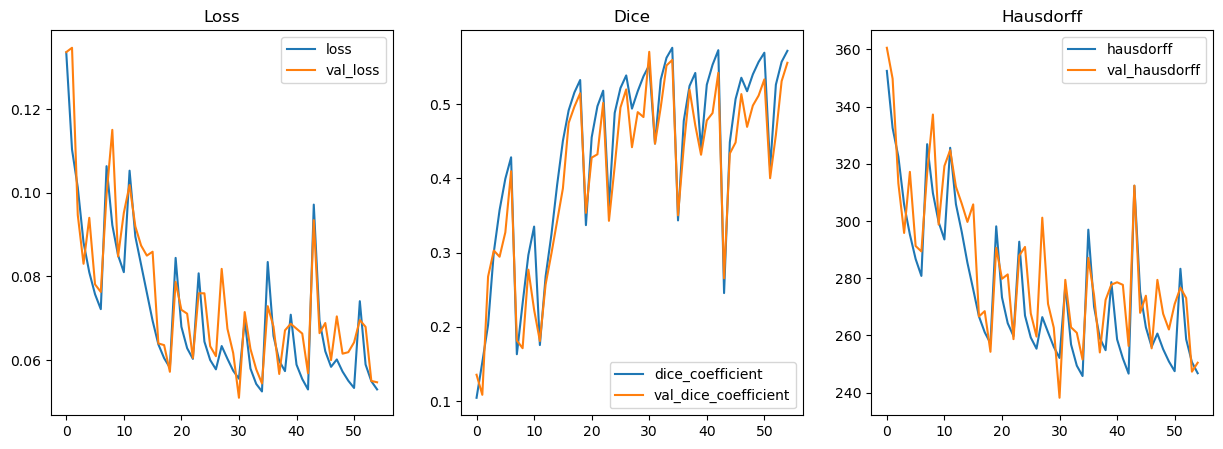

In [ ]:
loss = np.array(history['loss'])
val_loss = np.array(history['val_loss'])

metr_hausdorff = np.array(history['hausdorff_distance'])
metr_val_hausdorff = np.array(history['val_hausdorff_distance'])

metr_f1_score = np.array(history['dice_coefficient'])
metr_val_f1_score = np.array(history['val_dice_coefficient'])

fig = plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)

plt.plot(range(len(loss)), loss, label='loss')
plt.plot(range(len(loss)), val_loss, label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,3,2)
plt.plot(range(len(metr_f1_score)), metr_f1_score, label='dice_coefficient')
plt.plot(range(len(metr_f1_score)), metr_val_f1_score, label='val_dice_coefficient')
plt.legend()
plt.title('Dice')

plt.subplot(1,3,3)
plt.plot(range(len(metr_hausdorff)), metr_hausdorff, label='hausdorff')
plt.plot(range(len(metr_hausdorff)), metr_val_hausdorff, label='val_hausdorff')
plt.legend()
plt.title('Hausdorff')

plt.show()

### Test del modello

A partire dal modello addestrato, di cui abbiamo salvato il miglior checkpoint, possiamo procedere alla valutazione delle prestazioni in fase di predizione.

Per far ciò, ricreiamo lo scheletro del modello (inteso come la dichiarazione e la compilazione dello stesso) e carichiamo i pesi con la funzione `load_weights` dell'oggetto `Model`

In [ ]:
model_path = '/kaggle/working/model_checkpoint.hdf5'

model = unet_2d()

model.compile(optimizer=adam, metrics=[hausdorff_distance, dice_coefficient], loss='categorical_crossentropy')

model.load_weights(model_path)

Carichiamo una slice dal test set e la maschera ad esso associata.

In [ ]:
mask_test_set = '/kaggle/input/dataset-2d/dataset/test/masks/'
slice_test_set = '/kaggle/input/dataset-2d/dataset/test/slices/'

slice = cv.imread(f'{slice_test_set}20.png', cv.IMREAD_GRAYSCALE)
mask = cv.imread(f'{mask_test_set}20.png', cv.IMREAD_GRAYSCALE)

Processiamo slice e maschera allo stesso modo del data generator

In [ ]:
new_mask = np.zeros_like(mask)

new_mask[mask == 0] = 0
new_mask[mask == 80] = 1
new_mask[mask == 160] = 2
new_mask[mask == 240] = 3

# Scaliamo le immagini nel range [0, 1]
slice = np.asarray(slice).astype(np.float32) / 255

# Impostiamo la shape dei tensori a (256, 256, 1)
slice = np.expand_dims(slice, -1)
slice = np.expand_dims(slice, 0)

# Convertiamo i vettori delle classi in matrici binarie
mask = to_categorical(np.asarray(new_mask), num_classes=4)
mask = np.expand_dims(mask, 0)

Effettuiamo, quindi, una valutazione delle prestazioni del modello sulla slice e la rispettiva maschera

In [ ]:
model.evaluate(slice, mask, batch_size = 1)

1/1 [==============================] - 3s 3s/step - loss: 0.0691 - hausdorff_distance: 55.2698 - dice_coefficient: 4.1668e-04


[0.06910017877817154, 55.269775390625, 0.0004166816361248493]

Osservando i valori ottenuti, possiamo dedurre che è il modello abbia fatto una discreta previsione della maschera di segmentazione.

Passiamo, allora, alla generazione vera e propria della maschera predetta, usando il metodo `predict` dell'oggetto `Model`

In [ ]:
mask_predict = model.predict(slice, batch_size = 1)[0]

1/1 [==============================] - 2s 2s/step


Visualizziamo quindi le varie classi della predizione, in modo da poter dare anche una valutazione visiva.

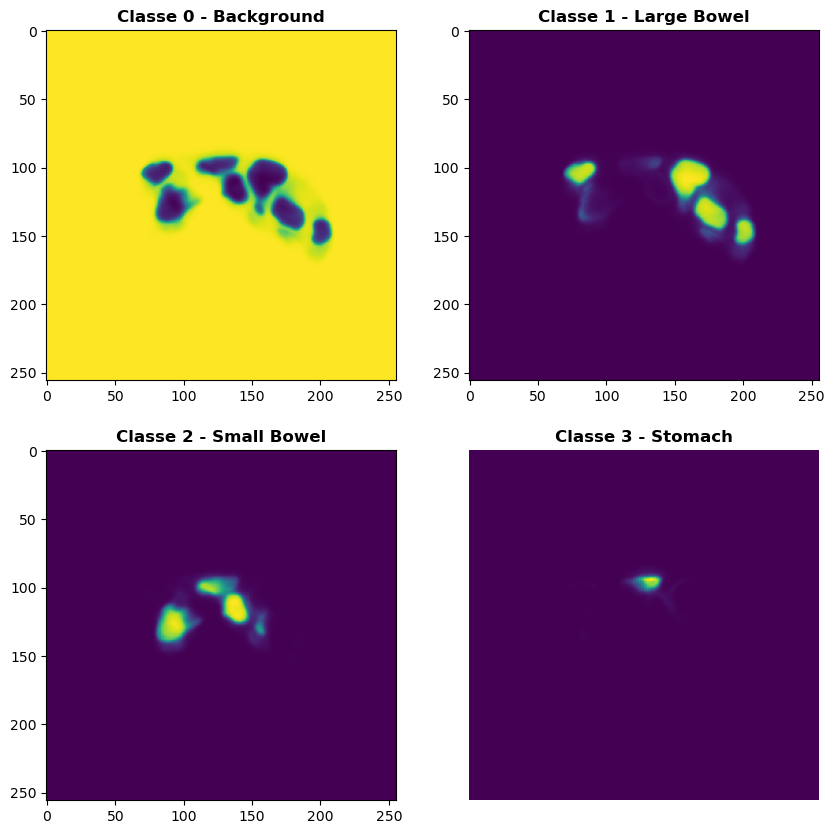

In [ ]:
class_0 = mask_predict[:, :, 0]
class_1 = mask_predict[:, :, 1]
class_2 = mask_predict[:, :, 2]
class_3 = mask_predict[:, :, 3]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(class_0)
axs[0, 0].set_title('Classe 0 - Background', fontweight='bold')

axs[0, 1].imshow(class_1)
axs[0, 1].set_title('Classe 1 - Large Bowel', fontweight='bold')

axs[1, 0].imshow(class_2)
axs[1, 0].set_title('Classe 2 - Small Bowel', fontweight='bold')

axs[1, 1].imshow(class_3)
axs[1, 1].set_title('Classe 3 - Stomach', fontweight='bold')

plt.axis('off')

# Visualizzazione dell'immagine
plt.show()

Come si può notare, le classi di interesse hanno dei contorni "sfocati": questo avviene perchè l'output della rete è una distribuzione di probabilità per ogni pixel che ne indica l'appartenenza a una delle quattro classi. 

Usiamo quindi la funzione `argmax` di NumPy per generare un'immagine in cui ogni pixel è assegnato alla classe più probabile.

In [ ]:
predicted_classes = np.argmax(mask_predict, axis=-1)

Possiamo, arrivati a questo punto, confrontare il risultato della predizione con la ground truth con l'ausilio del modulo `pyplot` di `matplotlib`.

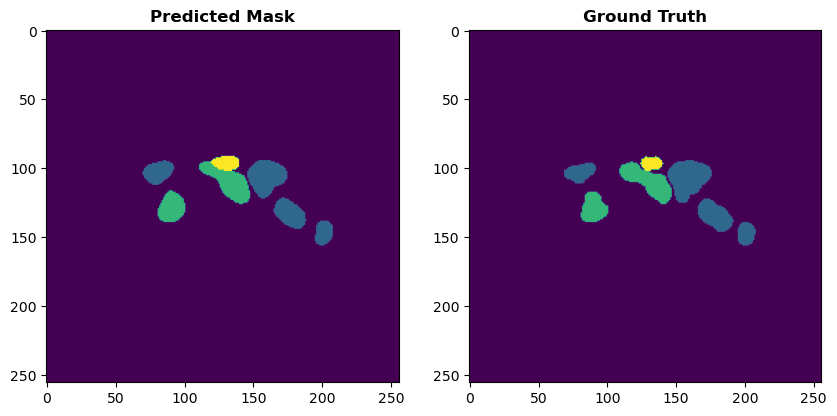

In [ ]:
ground_truth = cv.imread(f'{mask_test_set}20.png', cv.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(predicted_classes)
axs[0].set_title('Predicted Mask', fontweight='bold')

axs[1].imshow(ground_truth)
axs[1].set_title('Ground Truth', fontweight='bold')

plt.show()


<style>
  footer {
    color: #0f5b99;
    background-color: #f7f7f7;
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 10px;
    box-shadow: 0 2px 4px rgba(0,0,0,0.2);
  }
  
  footer p {
    font-family: 'Montserrat', 'Arial', sans-serif;
    font-size: 16px;
    margin: 10px;
    text-shadow: 1px 1px #f7f7f7;
  }
  
  .team {
    text-align: left;
  }
  
  .subject {
    text-align: center;
  }
  
  .professor {
    text-align: right;
  }
</style>
<a href="#inizio">
  <footer>
    <p class="team"><strong>Vincenzo Fardella</strong> & <strong>Mario Tortorici</strong></p>
    <p class="subject"><strong>Big Data</strong> &copy; <strong>2023</strong></p>
    <p class="professor">Prof. <strong>Roberto Pirrone</strong></p>
  </footer>
</a>